In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device",jax.devices()[2])
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
)
from plotting import plot_input_data

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2885.72it/s]


## Compute collocation points, insert sample points

In [3]:
num_grid_x = 26
num_grid_t = 26

#Build a collocation grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

tx_all = jnp.vstack([tx_bdy,tx_int])

#Observe on initial+final+boundary
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
u_true = u_true_function(tx_all)

x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])
u_obs = u_true_function(tx_obs)


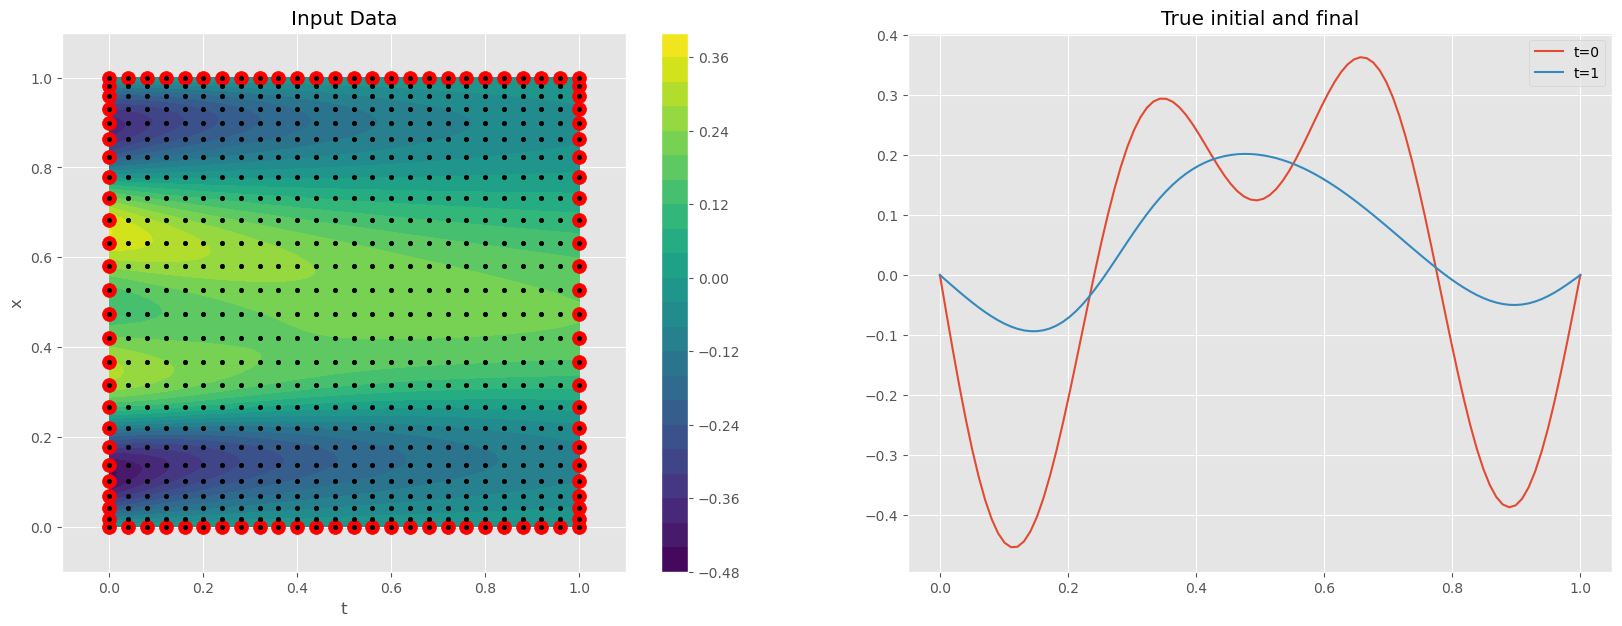

In [4]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 10)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

plt.subplot(1,2,2)
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()


## Setup model

In [5]:
from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF,
    get_anisotropic_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k


u_operators = (eval_k,dx_k,dt_k,dxx_k)
feature_operators = (eval_k,dx_k,dxx_k)

k_u = get_gaussianRBF(jnp.sqrt(0.025/2))
# k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,100])))

u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

from KernelTools import vectorize_kfunc
@vectorize_kfunc
def k_P(x,y):
    return 10*k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

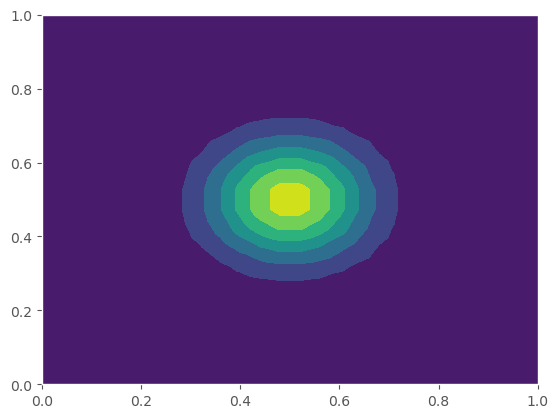

In [6]:
plt.tricontourf(tx_all[:,0],tx_all[:,1],vectorize_kfunc(k_u)(jnp.array([[0.5,0.5]]),tx_all)[0])

In [7]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import (
    CholeskyLM,SVD_LM,LMParams,plot_optimization_results
)

optParams = LMParams(
    max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

params_init = jnp.hstack([u_params_init,jnp.zeros(EqnModel.num_operator_params)])

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    optParams=optParams
)
svd_params = LMParams(
    max_iter=201,
    init_alpha=convergence_data.alpha_vals[-1],
    min_alpha=1e-16,print_every=50,
    step_adapt_multiplier=1.6)


p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,beta = 1e-16,optParams=svd_params)

  1%|          | 3/251 [00:30<32:19,  7.82s/it]  

Iteration 0, loss = 0.0922, gradnorm = 1.435e+03, alpha = 0.8543, improvement_ratio = 0.581
Iteration 1, loss = 0.04147, gradnorm = 2.096e+03, alpha = 0.8543, improvement_ratio = 0.7415
Iteration 2, loss = 0.01907, gradnorm = 308.5, alpha = 0.7119, improvement_ratio = 0.9331
Iteration 3, loss = 0.01214, gradnorm = 209.3, alpha = 0.5933, improvement_ratio = 0.9133


  4%|▎         | 9/251 [00:30<06:37,  1.64s/it]

Iteration 4, loss = 0.00854, gradnorm = 222.1, alpha = 0.4944, improvement_ratio = 0.8785
Iteration 5, loss = 0.005708, gradnorm = 281.7, alpha = 0.412, improvement_ratio = 0.9675


 22%|██▏       | 54/251 [00:32<00:08, 22.25it/s]

Iteration 50, loss = 4.194e-06, gradnorm = 4.712, alpha = 0.0001126, improvement_ratio = 0.9249


 42%|████▏     | 105/251 [00:34<00:05, 24.82it/s]

Iteration 100, loss = 3.61e-08, gradnorm = 0.3208, alpha = 2.139e-08, improvement_ratio = 0.504


 61%|██████    | 153/251 [00:36<00:04, 23.32it/s]

Iteration 150, loss = 1.253e-08, gradnorm = 0.03482, alpha = 1.522e-08, improvement_ratio = 0.6709


 81%|████████▏ | 204/251 [00:38<00:02, 23.11it/s]

Iteration 200, loss = 9.372e-09, gradnorm = 0.04866, alpha = 1.502e-08, improvement_ratio = 0.9983


100%|██████████| 251/251 [00:40<00:00,  6.20it/s]


Iteration 250, loss = 7.872e-09, gradnorm = 0.01524, alpha = 1.482e-08, improvement_ratio = 0.9987


  1%|          | 2/201 [00:25<34:26, 10.38s/it]  

Iteration 0, loss = 7.846e-09, gradnorm = 0.001706, alpha = 9.261e-09, improvement_ratio = 0.9997
Iteration 1, loss = 7.804e-09, gradnorm = 0.0007528, alpha = 5.788e-09, improvement_ratio = 0.9995


  2%|▏         | 4/201 [00:25<11:28,  3.49s/it]

Iteration 2, loss = 7.74e-09, gradnorm = 0.001884, alpha = 3.617e-09, improvement_ratio = 0.9988
Iteration 3, loss = 7.64e-09, gradnorm = 0.004679, alpha = 2.261e-09, improvement_ratio = 0.9967


  3%|▎         | 6/201 [00:25<04:59,  1.54s/it]

Iteration 4, loss = 7.489e-09, gradnorm = 0.01135, alpha = 1.413e-09, improvement_ratio = 0.9898
Iteration 5, loss = 7.272e-09, gradnorm = 0.02692, alpha = 8.832e-10, improvement_ratio = 0.9676


 26%|██▌       | 52/201 [00:30<00:16,  9.21it/s]

Iteration 50, loss = 2.229e-10, gradnorm = 0.09699, alpha = 2.167e-13, improvement_ratio = 0.9769


 51%|█████     | 102/201 [00:36<00:10,  9.20it/s]

Iteration 100, loss = 8.86e-11, gradnorm = 0.005374, alpha = 1.705e-13, improvement_ratio = 0.679


 76%|███████▌  | 152/201 [00:41<00:05,  9.20it/s]

Iteration 150, loss = 6.904e-11, gradnorm = 0.006057, alpha = 1.554e-13, improvement_ratio = 0.9856


100%|██████████| 201/201 [00:46<00:00,  4.29it/s]


Iteration 200, loss = 5.874e-11, gradnorm = 0.008551, alpha = 6.411e-14, improvement_ratio = 0.9219


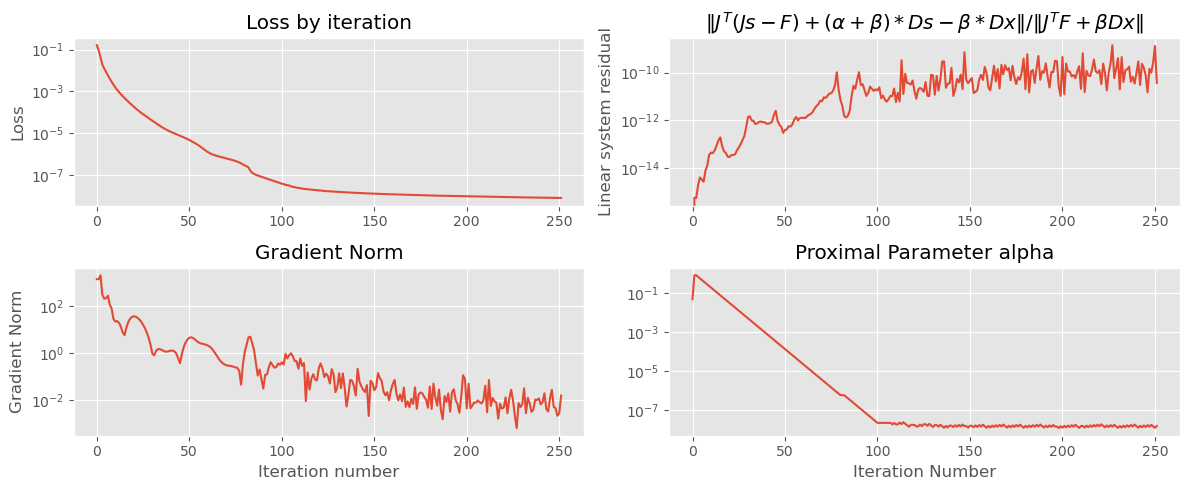

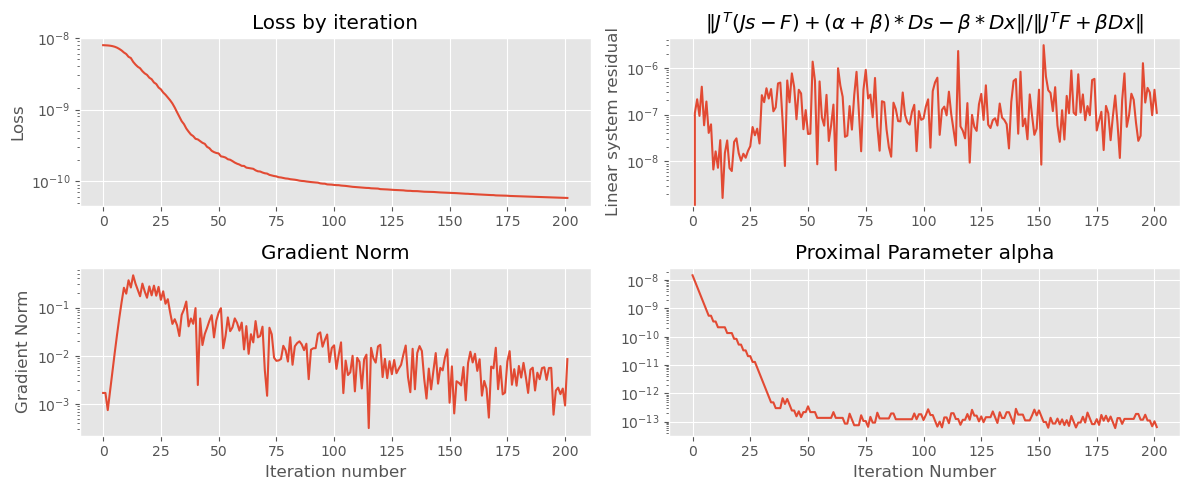

In [8]:
plot_optimization_results(convergence_data)
plot_optimization_results(refine_convergence_data)

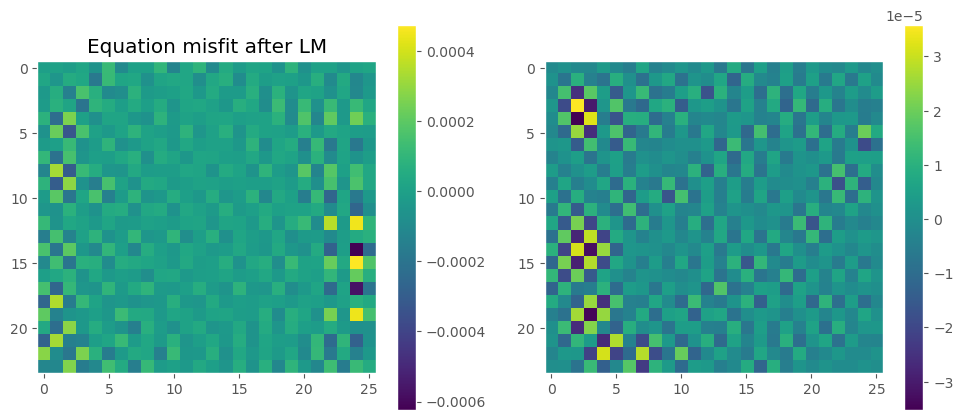

Pre Refinement  1.0712492983130565e-08
Post Refinement  9.01177578779333e-11


In [9]:
equation_residuals = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(params),EqnModel.get_P_params(params)
    )

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()
plt.subplot(1,2,2)

equation_residuals_refined = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(p_adjusted),EqnModel.get_P_params(p_adjusted)
    )
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

,NRMSE,NMAE
1 Step,0.003575,0.002967
2 Step,0.738156,0.681482


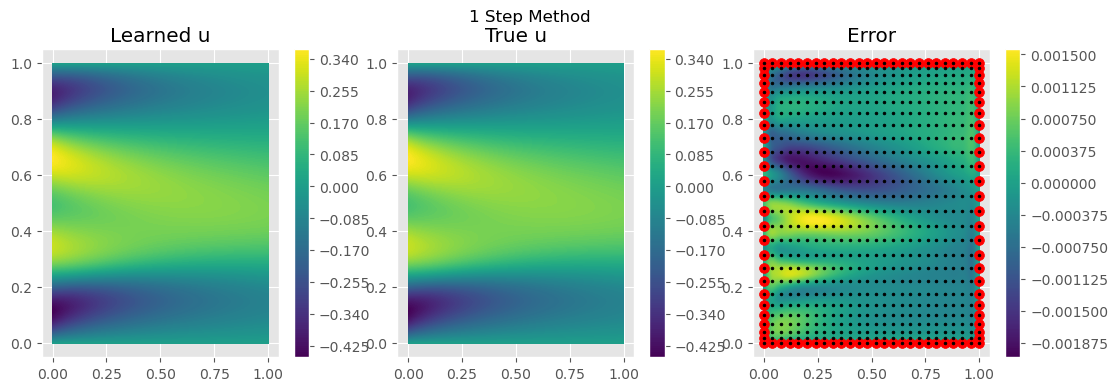

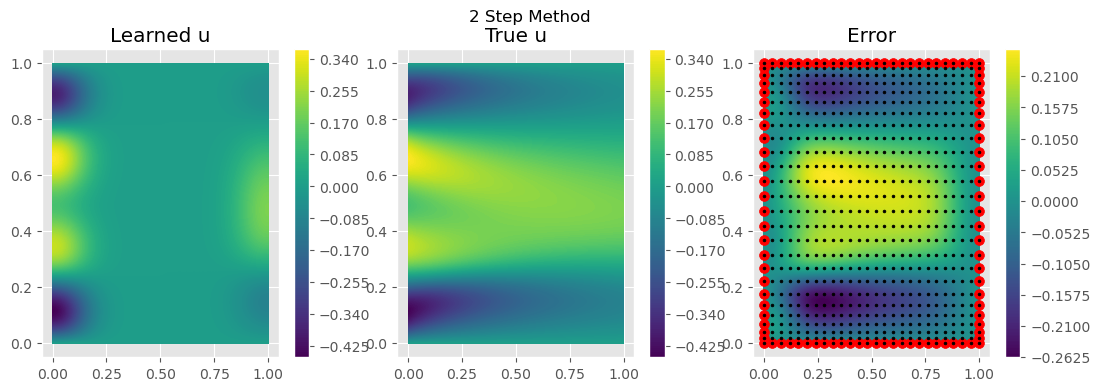

In [10]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

## PINN-SR

In [11]:
def get_data_for_pinns(n_coll_t, n_coll_x):
    # Solve Burgers' equations with IC u_0_true_function
    k = 5e-4
    kappa = 0.01
    alpha = 0.5
    def func_u0(x):
        u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
        return u0

    u_true_function,ut_true_function,interpolant,t_vals,sols = (
        build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                            )
    
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],n_coll_t,n_coll_x,alpha = 0.5)

    # Get (X^m, u^m(X^m))
    tx_all = jnp.vstack([tx_bdy,tx_int])

    #Observe on initial+final+boundary
    init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
    num_init_obs_inds = len(init_obs_inds)
    final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
    u_true = u_true_function(tx_all)

    x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
    tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])
    u_obs = u_true_function(tx_obs)
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs 
    u_train = u_true_function(tx_train) 
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    # plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)
    
    plot_input_data(
        tx_train, 
        tx_all,
        u_true_function,
        tx_fine,
                )

    num_fine_grid = 200
    t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
    tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plt.title('u_true')
    
    u_true = u_true_function(tx_grid_fine)
    # plt.tricontourf(*tx_fine_int.T, u_true,200)
    # plt.colorbar()
    # plt.xlabel('t')
    # plt.ylabel('x')


    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [u_true, tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

100%|██████████| 10099/10099 [00:03<00:00, 3040.55it/s]


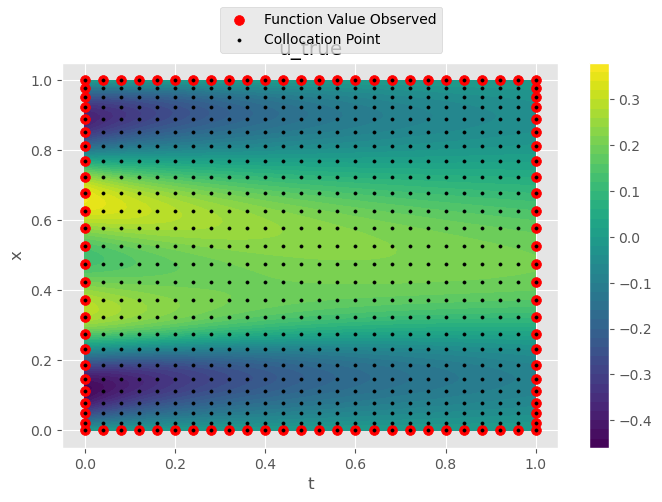

In [12]:
data_in_PINNSR = get_data_for_pinns(n_coll_t = 26, n_coll_x = 26)
data_in_PINNSR = list(map(np.array,data_in_PINNSR))

In [85]:
np.save('data_in_PINNSR.npy', np.array(data_in_PINNSR, dtype=object), allow_pickle=True)

In [86]:
data_out_PINNSR = jnp.load('data_out_PINNSR.npy',allow_pickle = True)

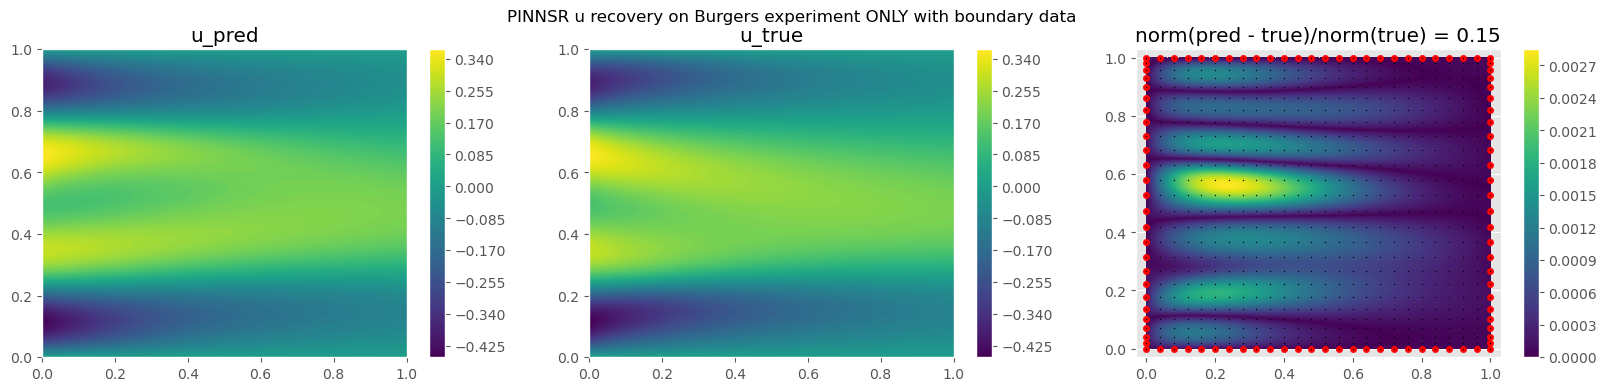

In [92]:
# Plot results for PINNSR 
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
fig.suptitle('PINNSR u recovery on Burgers experiment ONLY with boundary data')
pred = data_out_PINNSR[1].flatten()
true = data_in_PINNSR[0].flatten()
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,2))
ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.show()

## All results

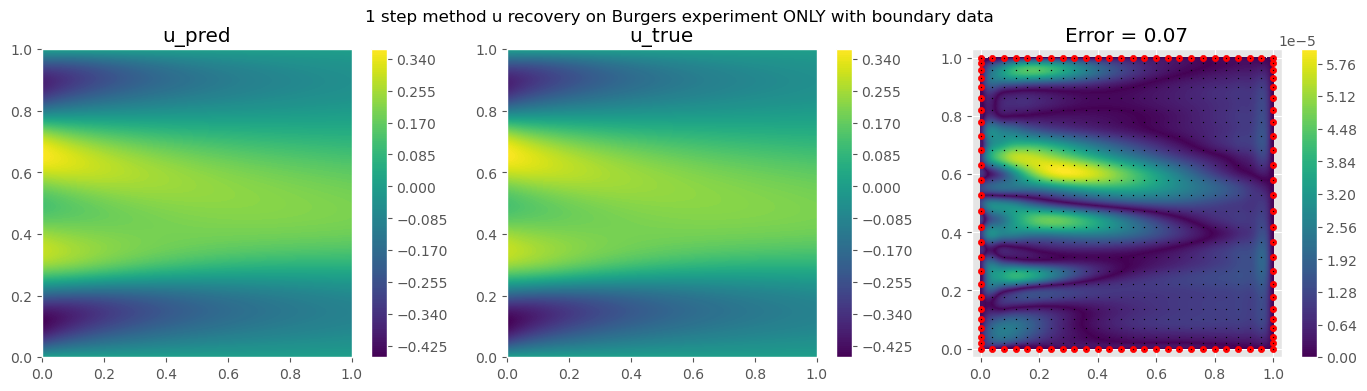

In [99]:
# Plot results for 1 step
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (17,4))
fig.suptitle('1 step method u recovery on Burgers experiment ONLY with boundary data')
pred = u_model.point_evaluate(tx_grid_fine,u_sol)
true = data_in_PINNSR[0].flatten()
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,5))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.savefig('1_step_burgers_bdrydata',dpi = 300)
plt.show()

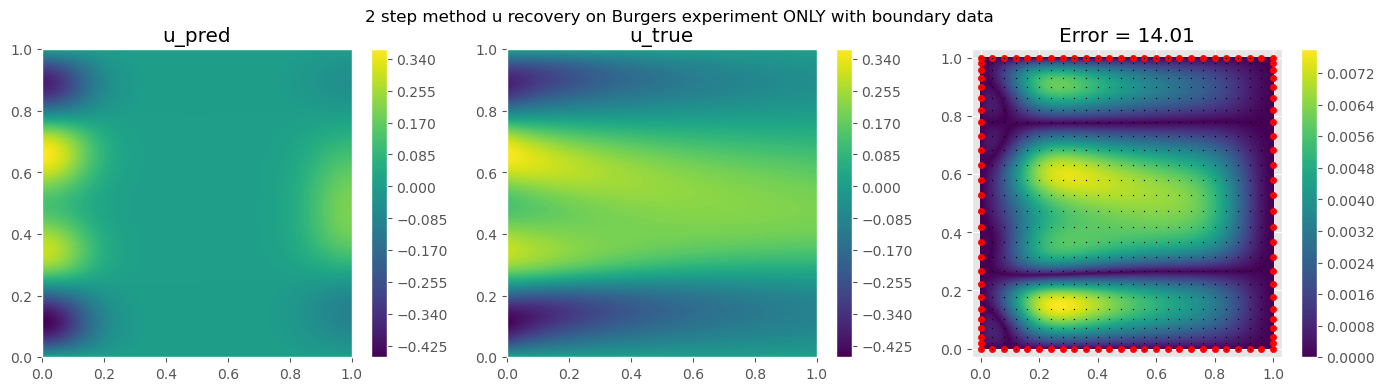

In [13]:
# Plot results for 2 step
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (17,4))
fig.suptitle('2 step method u recovery on Burgers experiment ONLY with boundary data')
pred = u_model.point_evaluate(tx_grid_fine,u_params_init)
true = data_in_PINNSR[0].flatten()
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,5))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.savefig('2_step_burgers_bdrydata',dpi = 300)
plt.show()

# Do the solving of this for a new initial conditions for our methods